In [2]:
import os
import json
from collections import defaultdict

base_dir = "/home/yifan50/rl/evaluate_outputs_test"

model_folders_by_name = defaultdict(list)

def extract_model_name(folder_name):
    special_keys = ['alpha_0.25', 'alpha_0.75', 'tau_1_',  'tau_1e-1',  'tau_1e-2']
    special_part = ''
    for key in special_keys:
        if key in folder_name:
            special_part = key
            break
    parts = folder_name.split('_epoch_')[0]
    if "random_1_True" not in folder_name and "random_3_True" not in folder_name and special_part:
        parts = parts.replace(f"_{special_part}", '')
        return f"{special_part}_{parts}"
    else:
        return parts


for folder_name in os.listdir(base_dir):
    full_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(full_path) and "_epoch_" in folder_name:
        model_name = extract_model_name(folder_name)
        model_folders_by_name[model_name].append(full_path)

for model_name, folder_paths in model_folders_by_name.items():
    assert len(folder_paths) == 30, f"{model_name} 有 {len(folder_paths)} 个文件夹，不是 30"
    print(f"\n模型名: {model_name}（共 30 个 epoch 文件夹）")

    count_to_paths = defaultdict(list)

    for path in folder_paths:
        dataset_folders = [
            f for f in os.listdir(path)
            if os.path.isdir(os.path.join(path, f))
        ]
        count_to_paths[len(dataset_folders)].append(os.path.basename(path))

    for count, paths in sorted(count_to_paths.items()):
        print(f"数据集文件夹数量为 {count} 的模型文件夹有 {len(paths)} 个示例")



模型名: replay_prob_random_teacher_model_Qwen2.5-3B_dataset_deepscaler_10240（共 30 个 epoch 文件夹）
数据集文件夹数量为 4 的模型文件夹有 30 个示例


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None
skip_list = None
show_list = None

eval_data_filter = ["math-500", "gsm8k", "minerva_math", "gaokao2023en", "amc23", "olympiadbench", "aime24"]
eval_data_filter = ["math-500", "gsm8k", "minerva_math", "olympiadbench", "gaokao2023en"]

skip_list = ["random-3"]
show_list = ["random-1", "ours-0.5-1e-3"]

#----------------------------------------------------------------#


base_dir = "/home/yifan50/rl/evaluate_outputs_test"
data = []

for model_name in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model_name)
    if not os.path.isdir(model_path):
        continue

    for eval_data_name in os.listdir(model_path):
        eval_data_path = os.path.join(model_path, eval_data_name)
        if not os.path.isdir(eval_data_path):
            continue 

        for filename in os.listdir(eval_data_path):
            if filename.endswith("_metrics.json"):
                file_path = os.path.join(eval_data_path, filename)
                
                parts = filename.split("_")
                assert len(parts) == 5 
                prompt = parts[0]
                seed = parts[1].replace("seed", "")
                temperature = parts[2][1:]  
                max_token = parts[3]

                with open(file_path, "r") as f:
                    json_data = json.load(f)
                
                acc = json_data.get("acc", None)  # Extract accuracy
                
                data.append([model_name, eval_data_name, prompt, seed, temperature, max_token, acc])

df = pd.DataFrame(data, columns=["Model", "Evaluation Data", "Prompt", "Seed", "Temperature", "Max Token", "Accuracy"])
df = df[df["Model"].str.contains("3B")]

import re
def extract_global_step(model_name):
    match = re.search(r'global_step_(\d+)', model_name)
    if match:
        step = int(match.group(1))
        return step//2 if "bs_256" in model_name else step
    else:
        raise

df = df.sort_values(by=["Model", "Prompt"], key=lambda x: x.map(extract_global_step) if x.name == "Model" else x)

columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
if columns_to_drop:
    for col in columns_to_drop:
        print(f"{col}: {df[col].iloc[0] if not df.empty else 'N/A'}")

df.drop(columns=columns_to_drop, inplace=True)
df.sort_values(by="Accuracy", ascending=False)

def strip_model_name(model_name):
    return re.sub(r'_global_step_\d+', '', model_name)

def extract_name(model_name):
    parts = model_name.split('_epoch_')
    prefix = parts[0]
    suffix = parts[1] if len(parts) > 1 else ""
    
    if 'random_1_True' in prefix or 'random_3_True' in prefix:
        return prefix
    elif suffix.endswith('mu_2'):
        return prefix
    elif 'mu_2_' in suffix:
        postfix = suffix.split('mu_2_')[-1]
        return f"{prefix}_{postfix}"
    else:
        return prefix


def parse_model_name(full_name):
    try:
        parts = full_name.split("_model_")
        prefix = parts[0]
        model_and_dataset = parts[1]
        model_parts = model_and_dataset.split("_dataset_")
        model = model_parts[0]
        dataset_raw = model_parts[1]

        if "tau_" in dataset_raw and "alpha_" in dataset_raw:
            tau = dataset_raw.split("tau_")[1].split("_")[0]
            alpha = dataset_raw.split("alpha_")[1].split("_")[0]
            if "new" in dataset_raw:
                method = f"ours-{alpha}-{tau}-new"
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
            else:
                method = f"ours-{alpha}-{tau}"
                dataset = dataset_raw.split("tau_")[0].rstrip("_")
        elif "random_1_True" in prefix:
            method = "random-1"
            dataset = dataset_raw
        elif "random_3_True" in prefix:
            method = "random-3"
            dataset = dataset_raw
        elif prefix == "rejection_sampling":
            method = "rs"
            dataset = dataset_raw
        else:
            method = prefix  # fallback
            dataset = dataset_raw

        return pd.Series([model, dataset, method])

    except Exception as e:
        raise e

df["steps"] = df["Model"].map(extract_global_step)
df["Model"] = df["Model"].map(strip_model_name)
df["Name"] = df["Model"].map(extract_name)
df[["Model", "Train Data", "Method"]] = df["Name"].apply(parse_model_name)
df = df[df["steps"] <= 60]
df = df[df["Evaluation Data"].isin(eval_data_filter)]
df['Train Data'].unique()
# df

ValueError: Columns must be same length as key

math-500 random-1 30
gsm8k random-1 30
minerva_math random-1 30
olympiadbench random-1 30
gaokao2023en random-1 30


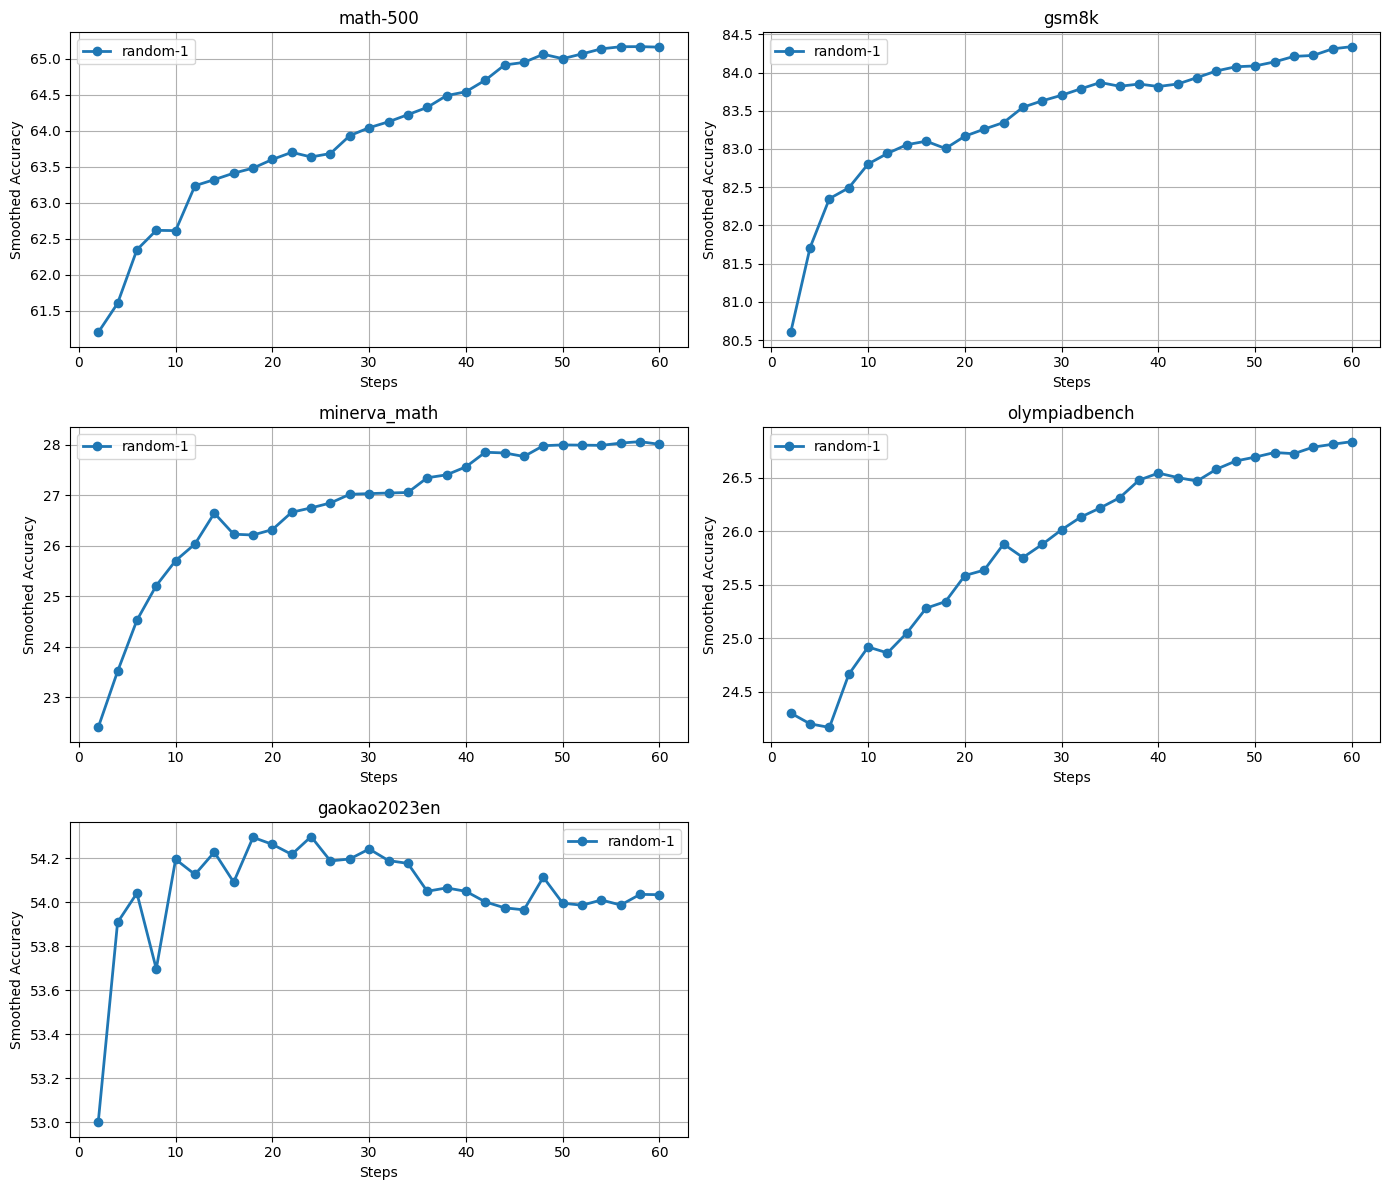

Evaluation Data,gaokao2023en,gsm8k,math-500,minerva_math,olympiadbench,Average
Method,,,,,,
random-1,54.03,84.34,65.16,28.01,26.84,51.68


,Evaluation Data,Saved (%)
0,Average,NaN


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

def get_results(train_data_name):
    if isinstance(train_data_name, str):
        df_subset = df[df["Train Data"] == train_data_name]
    else:
        df_subset = df[df["Train Data"].isin(train_data_name)]
        df_subset = df[df["Train Data"].isin(train_data_name)].copy()
        df_subset["Method"] = df_subset["Method"] + "_" + df_subset["Train Data"]

    smoothing_param = 0.99
    viewport_scale = 100

    def smoothing(x, y, smoothing_param=0.99, viewport_scale=100):
        assert len(x) == len(y)
        if len(x) == 0:
            return np.array([])

        smoothing_weight = min(np.sqrt(smoothing_param), 0.999)
        range_of_x = max(x) - min(x) if max(x) != min(x) else 1e-8

        smoothed = []
        last_y = 0.0
        debias_weight = 0.0

        for i in range(len(y)):
            prev_i = i - 1 if i > 0 else 0
            delta_x = (x[i] - x[prev_i]) / range_of_x * viewport_scale
            smoothing_weight_adj = smoothing_weight ** delta_x

            last_y = last_y * smoothing_weight_adj + y[i]
            debias_weight = debias_weight * smoothing_weight_adj + 1
            smoothed.append(last_y / debias_weight)

        return np.array(smoothed)

    n_cols = 2
    n_rows = (len(eval_data_filter) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()  

    results = [] 

    for i, eval_data in enumerate(eval_data_filter):
        ax = axes[i]
        subset = df_subset[df_subset["Evaluation Data"] == eval_data]

        for method in subset["Method"].unique():
            if skip_list is not None and method in skip_list:
                continue
            if show_list is not None and method not in show_list:
                continue
            method_df = subset[subset["Method"] == method]
            # assert(len(method_df) == 30)
            print(eval_data, method, len(method_df))
            method_df = method_df.sort_values("steps")

            x = method_df["steps"].tolist()
            y = method_df["Accuracy"].tolist()
            y_smooth = smoothing(x, y, smoothing_param=smoothing_param, viewport_scale=viewport_scale)

            final_acc = round(y_smooth[-1], 4) if len(y_smooth) > 0 else np.nan
            results.append((eval_data, method, final_acc))  

            ax.plot(x, y_smooth, label=method, linewidth=2, marker='o')

        ax.set_title(f"{eval_data}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Smoothed Accuracy")
        ax.grid(True)
        ax.legend()

    for j in range(len(eval_data_filter), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    efficiency_results = []

    for eval_data in eval_data_filter:
        subset = df_subset[df_subset["Evaluation Data"] == eval_data]

        rand_df = subset[subset["Method"] == "random-1"].sort_values("steps")
        if len(rand_df) == 0:
            continue
        x_rand = rand_df["steps"].tolist()
        y_rand = rand_df["Accuracy"].tolist()
        y_rand_smooth = smoothing(x_rand, y_rand, smoothing_param=smoothing_param, viewport_scale=viewport_scale)
        acc_target = y_rand_smooth[-1]
        step_rand_final = x_rand[-1]

        ours_df = subset[subset["Method"] == "ours-0.5-1e-3"].sort_values("steps")
        if len(ours_df) == 0:
            continue
        x_ours = ours_df["steps"].tolist()
        y_ours = ours_df["Accuracy"].tolist()
        y_ours_smooth = smoothing(x_ours, y_ours, smoothing_param=smoothing_param, viewport_scale=viewport_scale)

        try:
            first_meeting_idx = next(i for i, acc in enumerate(y_ours_smooth) if acc >= acc_target)
            step_ours_needed = x_ours[first_meeting_idx]
            percent_saved = 1 - (step_ours_needed / step_rand_final)
            percent_saved = round(percent_saved * 100, 2)
        except StopIteration:
            percent_saved = None  

        efficiency_results.append((eval_data, percent_saved))

    df_saved = pd.DataFrame(efficiency_results, columns=["Evaluation Data", "Saved (%)"])
    average_saved = round(df_saved["Saved (%)"].mean(skipna=True), 2)
    df_saved.loc[len(df_saved)] = ["Average", average_saved]

    df_result = pd.DataFrame(results, columns=["Evaluation Data", "Method", "Final Smoothed Accuracy"])
    df_pivot = df_result.pivot(index="Method", columns="Evaluation Data", values="Final Smoothed Accuracy")
    df_pivot["Average"] = df_pivot.mean(axis=1, skipna=True)

    display(df_pivot.round(2))  
    display(df_saved)

get_results('math_hard_8192')
# get_results('math_11691')
# get_results('math_medium_7680')
# get_results('orz_9728')
# get_results('deepscaler_10240')
# get_results("math_easy_8192")
# get_results("deepscaler_subset1_8192")
# get_results("openr1_hard_8192")

# get_results(["deepscaler_subset1_8192", "deepscaler_subset3_8192", "deepscaler_10240"])
# get_results(["deepmath_8192", "openr1_hard_8192"])

In [10]:
import os
import torch
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

def compute_average_overlap(directory: str) -> float:
    directory += "/saved_selected_indices"
    files = [f for f in os.listdir(directory) if f.startswith("selected_indices_epoch_") and f.endswith(".pt")]
    if len(files) < 2:
        raise ValueError("Not enough epoch files to compute overlap.")
    
    def extract_epoch(filename):
        return int(filename.split("_")[-1].split(".")[0])
    
    files.sort(key=extract_epoch)
    
    overlaps = []
    for i in range(len(files) - 1):
        indices_1 = set(torch.load(os.path.join(directory, files[i])).tolist())
        indices_2 = set(torch.load(os.path.join(directory, files[i+1])).tolist())
        intersection_size = len(indices_1 & indices_2)
        union_size = len(indices_1 | indices_2)
        if union_size == 0:
            overlaps.append(0.0)
        else:
            overlaps.append(intersection_size / union_size)
    
    avg = round(sum(overlaps) / len(overlaps), 4)
    return overlaps, avg


def load_keys_from_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return set(data.keys())

def compute_rs_overlap(base_dir: str, prefix: str = "rollout_data_step_", steps: int = 60) -> float:
    base_dir += "/saved_data"
    assert steps % 2 == 0, "Step count must be even for pairing."

    merged_sets = []
    for i in range(1, steps + 1, 2):
        keys1 = load_keys_from_pkl(os.path.join(base_dir, f"{prefix}{i}.pkl"))
        keys2 = load_keys_from_pkl(os.path.join(base_dir, f"{prefix}{i + 1}.pkl"))
        merged_sets.append(keys1 | keys2)  

    overlaps = []
    for i in range(len(merged_sets) - 1):
        inter = len(merged_sets[i] & merged_sets[i + 1])
        union = len(merged_sets[i] | merged_sets[i + 1])
        overlaps.append(inter / union if union > 0 else 0.0)

    avg = round(sum(overlaps) / len(overlaps), 4)
    return overlaps, avg



In [11]:
all_curves = []

# final_teacher
teacher_base = "/srv/local/rl_models/ablation"
for subdir in os.listdir(teacher_base):
    full_path = os.path.join(teacher_base, subdir)
    if os.path.isdir(full_path):
        overlaps, avg = compute_average_overlap(full_path)
        label = subdir + f" (avg={avg})"
        all_curves.append((label, overlaps))


plt.figure(figsize=(10, 6))
for label, overlaps in all_curves:
    plt.plot(overlaps, label=label)

plt.title("Jaccard Overlap Curves")
plt.xlabel("Step Index")
plt.ylabel("Jaccard Overlap")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/srv/local/rl_models/ablation'

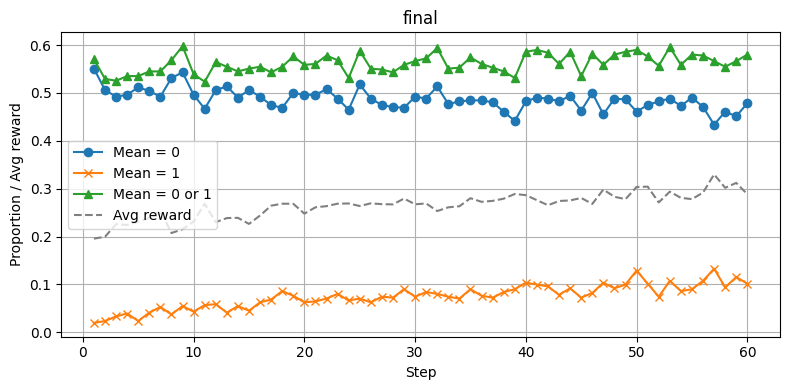

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt

def plot_single_reward_extreme_ratios(base_dir, steps=range(1, 61), title=None):
    def compute_stats(base_dir, steps):
        zero_ratio_per_step = []
        one_ratio_per_step = []
        zero_or_one_ratio_per_step = []
        avg_reward_per_step = []

        for step in steps:
            file_path = os.path.join(base_dir, f"saved_data/rollout_data_step_{step}.pkl")
            try:
                with open(file_path, "rb") as f:
                    data = pickle.load(f)

                zero_count = 0
                one_count = 0
                total_count = 0
                reward_sum = 0
                reward_count = 0

                for key in data:
                    rewards = data[key].get("rewards", [])
                    if isinstance(rewards, list) and len(rewards) > 0:
                        mean_reward = sum(rewards) / len(rewards)
                        total_count += 1
                        reward_sum += sum(rewards)
                        reward_count += len(rewards)
                        if mean_reward == 0:
                            zero_count += 1
                        elif mean_reward == 1:
                            one_count += 1

                if total_count > 0:
                    zero_ratio = zero_count / total_count
                    one_ratio = one_count / total_count
                    zero_or_one_ratio = (zero_count + one_count) / total_count
                else:
                    zero_ratio = one_ratio = zero_or_one_ratio = float('nan')

                if reward_count > 0:
                    avg_reward = reward_sum / reward_count
                else:
                    avg_reward = float('nan')

            except Exception:
                zero_ratio = one_ratio = zero_or_one_ratio = avg_reward = float('nan')

            zero_ratio_per_step.append(zero_ratio)
            one_ratio_per_step.append(one_ratio)
            zero_or_one_ratio_per_step.append(zero_or_one_ratio)
            avg_reward_per_step.append(avg_reward)

        return zero_ratio_per_step, one_ratio_per_step, zero_or_one_ratio_per_step, avg_reward_per_step

    # 自动命名标题
    if title is None:
        title = os.path.basename(os.path.dirname(base_dir))

    # 计算
    zero_ratios, one_ratios, both_ratios, avg_rewards = compute_stats(base_dir, steps)

    # 画图
    plt.figure(figsize=(8, 4))
    plt.plot(steps, zero_ratios, marker='o', label='Mean = 0')
    plt.plot(steps, one_ratios, marker='x', label='Mean = 1')
    plt.plot(steps, both_ratios, marker='^', label='Mean = 0 or 1')
    plt.plot(steps, avg_rewards, linestyle='--', color='gray', label='Avg reward')
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Proportion / Avg reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_single_reward_extreme_ratios("/home/yifan50/rl/deepscaler/output/models/final/random_1_True_model_Qwen2.5-Math-1.5B_dataset_openr1_hard_8192_epoch_30_bs_512_lr_1e-6_beta_0_entropy_0_mu_2_tau_1e-3_alpha_0.5")


In [7]:
import torch
torch.load("/home/yifan50/rl/deepscaler/output/models/final_teacher/cache/replay_random_teacher_model_Qwen2.5-Math-1.5B_dataset_math_hard_8192_epoch_30_bs_512_lr_1e-6_beta_0_entropy_0_mu_2_tau_1e-3_alpha_0.5_sigma_0.25_buffer_2048/saved_selected_indices/selected_indices_epoch_2.pt").shape

import pickle
with open("/home/yifan50/rl/deepscaler/output/models/final_teacher/cache/replay_random_teacher_model_Qwen2.5-Math-1.5B_dataset_math_hard_8192_epoch_30_bs_512_lr_1e-6_beta_0_entropy_0_mu_2_tau_1e-3_alpha_0.5_sigma_0.25_buffer_2048/saved_data/rollout_data_step_14.pkl","rb") as f:
    data = pickle.load(f)
len(data)

/tmp/ipykernel_3940379/1919078432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/home/yifan50/rl/deepscaler/output/models/final_teacher/cache/replay_random

438